# Tesla Stock Analysis

### Getting Data

In [4]:
import pandas as pd

tesla = pd.read_csv("TSLA_5_Minutes.csv")
# Combine 'Date' and 'Time' into single datetime column
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)

print(tesla)

         Open    High     Low   Close  Volume        Date      Time  \
0      215.25  215.30  210.96  211.79  246569  03-01-2017  09:35:00   
1      211.78  213.23  211.40  212.95  204410  03-01-2017  09:40:00   
2      212.92  215.20  212.86  214.99  183865  03-01-2017  09:45:00   
3      215.00  216.14  214.88  215.75  205415  03-01-2017  09:50:00   
4      215.79  218.31  215.67  218.04  250916  03-01-2017  09:55:00   
...       ...     ...     ...     ...     ...         ...       ...   
67283  943.59  946.00  943.30  945.60   63775  09-06-2020  15:40:00   
67284  945.61  946.94  945.17  945.63   73159  09-06-2020  15:45:00   
67285  945.44  945.58  941.12  942.53  104852  09-06-2020  15:50:00   
67286  942.21  942.91  939.56  939.80  130011  09-06-2020  15:55:00   
67287  939.92  942.20  939.55  941.01  145940  09-06-2020  16:00:00   

                 Datetime  
0     2017-01-03 09:35:00  
1     2017-01-03 09:40:00  
2     2017-01-03 09:45:00  
3     2017-01-03 09:50:00  
4     2

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

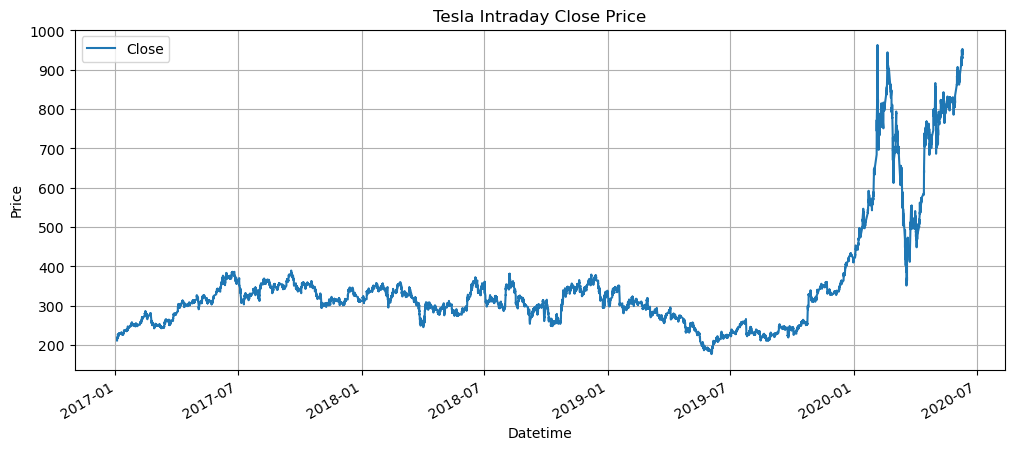

In [29]:
tesla.plot(x='Datetime', y='Close', figsize=(12, 5), title="Tesla Intraday Close Price")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.grid(True)
plt.show()

### Simple buy at open and sell at close trading strategy

In [37]:
# After (Correct)
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)
tesla = tesla.set_index('Datetime')

# --- Strategy Implementation ---
# Resample the 5-minute data to a daily frequency ('D')
# 'first' gets the first value of the day (the open)
# 'last' gets the last value of the day (the close)
daily_trades = tesla['Open'].resample('D').first().to_frame(name='Day_Open')
daily_trades['Day_Close'] = tesla['Close'].resample('D').last()

# Drop days where the market was closed (no trades)
daily_trades.dropna(inplace=True)

# Calculate the daily and cumulative Profit and Loss (PnL) for one share
daily_trades['PnL'] = daily_trades['Day_Close'] - daily_trades['Day_Open']
daily_trades['Cumulative_PnL'] = daily_trades['PnL'].cumsum()

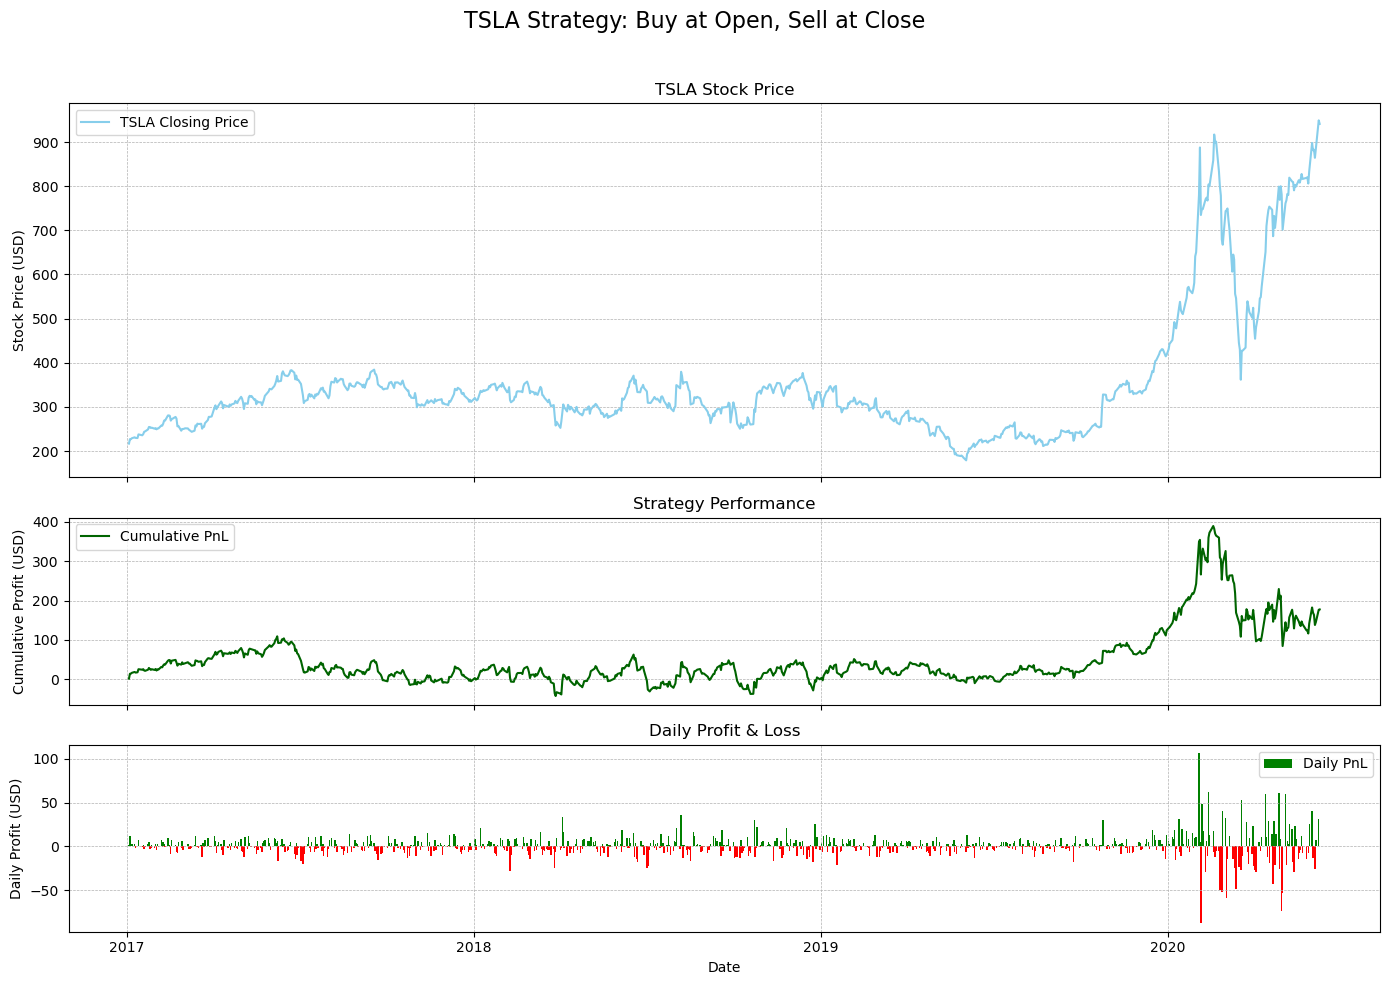

In [39]:
# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                                    gridspec_kw={'height_ratios': [2, 1, 1]})
fig.suptitle('TSLA Strategy: Buy at Open, Sell at Close', fontsize=16)

# Panel 1: Stock Price
ax1.plot(daily_trades.index, daily_trades['Day_Close'], label='TSLA Closing Price', color='skyblue')
ax1.set_ylabel('Stock Price (USD)')
ax1.set_title('TSLA Stock Price')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Panel 2: Cumulative PnL
ax2.plot(daily_trades.index, daily_trades['Cumulative_PnL'], label='Cumulative PnL', color='darkgreen')
ax2.set_ylabel('Cumulative Profit (USD)')
ax2.set_title('Strategy Performance')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend()

# Panel 3: Daily PnL
colors = ['g' if x > 0 else 'r' for x in daily_trades['PnL']]
ax3.bar(daily_trades.index, daily_trades['PnL'], color=colors, label='Daily PnL', width=1.5)
ax3.set_ylabel('Daily Profit (USD)')
ax3.set_title('Daily Profit & Loss')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.legend()

# Improve x-axis formatting
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Buy or sell when certain price deviation happens close at the end of the day. 

In [45]:
import pandas as pd

# Prepare the datetime index
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)
tesla = tesla.set_index('Datetime')

# Group data by day
grouped = tesla.groupby(tesla.index.date)

# Store daily trades
trade_results = []

for date, group in grouped:
    group = group.sort_index()  # Ensure chronological order
    
    day_open = group.iloc[0]['Open']
    day_close = group.iloc[-1]['Close']
    threshold_price = day_open * 1.005  # 0.5% increase
    
    # Look for first price that crosses threshold
    crossed = group[group['High'] >= threshold_price]
    
    if not crossed.empty:
        # Buy triggered at first threshold cross
        buy_time = crossed.index[0]
        buy_price = day_open  # As per your rule, buy at open if threshold is met later
        sell_price = day_close  # Sell at day close
        
        pnl = sell_price - buy_price
    else:
        # No trade that day
        pnl = 0.0
    
    trade_results.append({
        'Date': pd.to_datetime(date),
        'Day_Open': day_open,
        'Day_Close': day_close,
        'PnL': pnl
    })

# Convert to DataFrame
daily_trades = pd.DataFrame(trade_results)
daily_trades.set_index('Date', inplace=True)
daily_trades['Cumulative_PnL'] = daily_trades['PnL'].cumsum()

# Inspect result
print(daily_trades.head())

            Day_Open  Day_Close    PnL  Cumulative_PnL
Date                                                  
2017-01-03    215.25     216.92   1.67            1.67
2017-01-04    214.69     226.98  12.29           13.96
2017-01-05    226.42     226.76   0.00           13.96
2017-01-06    226.93     229.02   2.09           16.05
2017-01-09    228.97     231.20   2.23           18.28


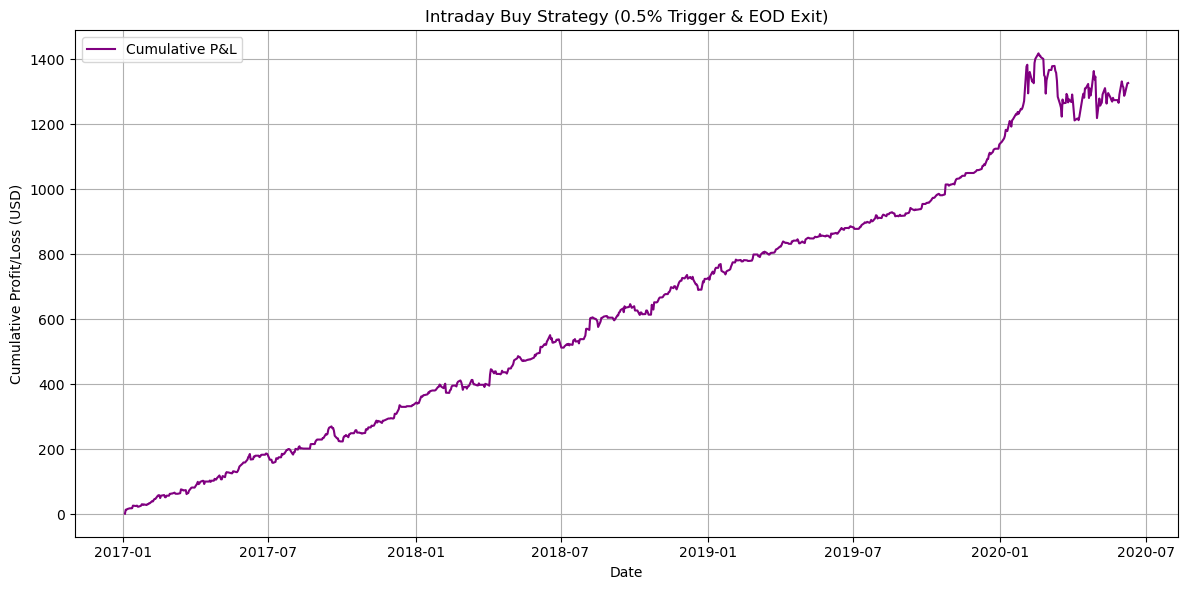

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(daily_trades.index, daily_trades['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Intraday Buy Strategy (0.5% Trigger & EOD Exit)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
trade_days = daily_trades[daily_trades['PnL'] != 0]

print(f"Total Profit/Loss: ${trade_days['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${trade_days['PnL'].mean():.2f}")
print(f"Number of Trades: {len(trade_days)}")
print(f"Winning Trades: {(trade_days['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trade_days['PnL'] < 0).sum()}")

Total Profit/Loss: $1327.07
Average Trade PnL: $1.91
Number of Trades: 695
Winning Trades: 435
Losing Trades: 260


### Adjusted conditional strategy with buy fix and stop loss

In [534]:
threshold = 0.5  # percent threshold to trigger trade
stop_loss_pct = 1.0  # optional stop loss (in percent)

# Clear old columns
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Intraday high/low returns from open (used for stop loss)
tesla["HighReturn"] = (tesla["High"] - tesla["Open"]) / tesla["Open"] * 100
tesla["LowReturn"] = (tesla["Low"] - tesla["Open"]) / tesla["Open"] * 100

# Loop through each row to simulate trades
for i, row in tesla.iterrows():
    ret = row["ReturnPct"]

    # ---- Long trade logic ----
    if ret >= threshold:
        tesla.at[i, "Position"] = "Long"

        # Check if stop loss is hit
        if row["LowReturn"] <= -stop_loss_pct:
            # Stop loss hit → exit at stop-loss price
            stop_price = row["Open"] * (1 - stop_loss_pct / 100)
            tesla.at[i, "PnL"] = stop_price - row["Open"]
        else:
            # Normal exit at close
            tesla.at[i, "PnL"] = row["Close"] - row["Open"]

    # ---- Short trade logic ----
    elif ret <= -threshold:
        tesla.at[i, "Position"] = "Short"

        if row["HighReturn"] >= stop_loss_pct:
            # Stop loss hit → exit at stop-loss price
            stop_price = row["Open"] * (1 + stop_loss_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - stop_price
        else:
            # Normal exit at close
            tesla.at[i, "PnL"] = row["Open"] - row["Close"]

tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100

# Cumulative PnL
tesla["Cumulative_PnL"] = tesla["PnL"].cumsum()


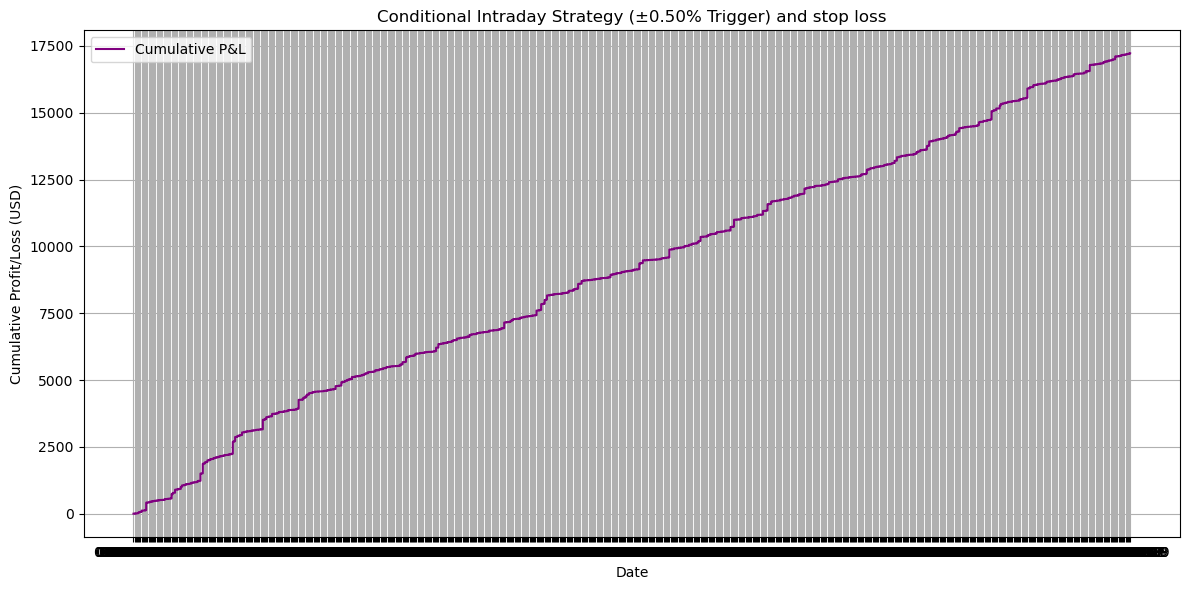

In [535]:
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Conditional Intraday Strategy (±0.50% Trigger) and stop loss')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [536]:
trades = tesla[tesla['Position'] != 'None']

In [540]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${tesla.loc[tesla['Position'] != 'None', 'PnL'].mean():.2f}")
print(f"Average Percent Return per Trade: {trades['ReturnPctTrade'].mean():.4f}%")
print(f"Max Return: {trades['ReturnPctTrade'].max():.2f}%")
print(f"Min Return: {trades['ReturnPctTrade'].min():.2f}%")
print(f"Number of Trades: {(tesla['Position'] != 'None').sum()}")
print(f"Winning Trades: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Trades: {(tesla['PnL'] < 0).sum()}")

Total Profit/Loss: $17219.58
Average Trade PnL: $3.55
Average Percent Return per Trade: 0.8055%
Max Return: 8.44%
Min Return: -1.00%
Number of Trades: 4852
Winning Trades: 4817
Losing Trades: 35


### Strategies performance vs buy and hold

In [543]:
total_profit = tesla['PnL'].sum()

In [545]:
total_cost = tesla.loc[tesla['Position'] != 'None', 'Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

In [547]:
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']

buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100

In [549]:
# Strategy return
trades = tesla[tesla['Position'] != 'None']
total_profit = trades['PnL'].sum()
total_cost = trades['Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

# Buy-and-hold return
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']
buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100

# Print summary
print(f"Total Profit from Strategy: ${total_profit:.2f}")
print(f"Total Capital Deployed: ${total_cost:.2f}")
print(f"Total Return (Strategy): {total_return_pct:.2f}%")

print(f"\nBuy and Hold Profit (1 share): ${buy_and_hold_profit:.2f}")
print(f"Buy and Hold Return: {buy_and_hold_return_pct:.2f}%")

Total Profit from Strategy: $17219.58
Total Capital Deployed: $2069928.86
Total Return (Strategy): 0.83%

Buy and Hold Profit (1 share): $166.40
Buy and Hold Return: 66.74%


In [551]:
# Starting capital
initial_capital = 1000

# Buy 1 share on first day, track its value over time
tesla['BuyHold_Value'] = tesla['Close'] / tesla.iloc[0]['Close'] * initial_capital

# Conditional strategy capital (starting from same base)
tesla['Strategy_Value'] = initial_capital + tesla['Cumulative_PnL']


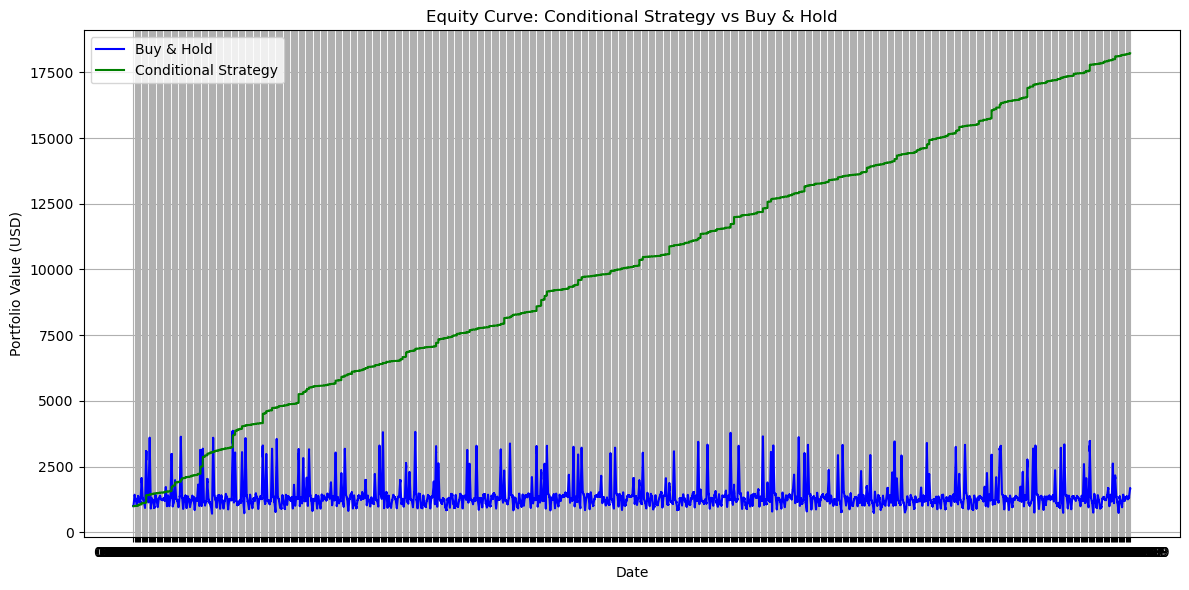

In [553]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['BuyHold_Value'], label='Buy & Hold', color='blue')
plt.plot(tesla['Date'], tesla['Strategy_Value'], label='Conditional Strategy', color='green')
plt.title('Equity Curve: Conditional Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Adding take profit logic

In [555]:
threshold = 0.6  # % move from open to trigger trade
stop_loss_pct = 2.0   # % from open
take_profit_pct = 8.0 # % from open

# Clear previous results
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Calculate high/low return from open (intraday)
tesla["HighReturn"] = (tesla["High"] - tesla["Open"]) / tesla["Open"] * 100
tesla["LowReturn"] = (tesla["Low"] - tesla["Open"]) / tesla["Open"] * 100

# Main loop
for i, row in tesla.iterrows():
    ret = (row["Close"] - row["Open"]) / row["Open"] * 100  # daily move

    # Long entry condition
    if ret >= threshold:
        tesla.at[i, "Position"] = "Long"
        if row["LowReturn"] <= -stop_loss_pct:
            # Hit SL
            stop_price = row["Open"] * (1 - stop_loss_pct / 100)
            tesla.at[i, "PnL"] = stop_price - row["Open"]
        elif row["HighReturn"] >= take_profit_pct:
            # Hit TP
            tp_price = row["Open"] * (1 + take_profit_pct / 100)
            tesla.at[i, "PnL"] = tp_price - row["Open"]
        else:
            # Exit at close
            tesla.at[i, "PnL"] = row["Close"] - row["Open"]

    # Short entry condition
    elif ret <= -threshold:
        tesla.at[i, "Position"] = "Short"
        if row["HighReturn"] >= stop_loss_pct:
            stop_price = row["Open"] * (1 + stop_loss_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - stop_price
        elif row["LowReturn"] <= -take_profit_pct:
            tp_price = row["Open"] * (1 - take_profit_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - tp_price
        else:
            tesla.at[i, "PnL"] = row["Open"] - row["Close"]


In [557]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")


Total Profit: $14089.05
Average % Return per Trade: 0.95%
Winning Trades: 3267
Losing Trades: 1


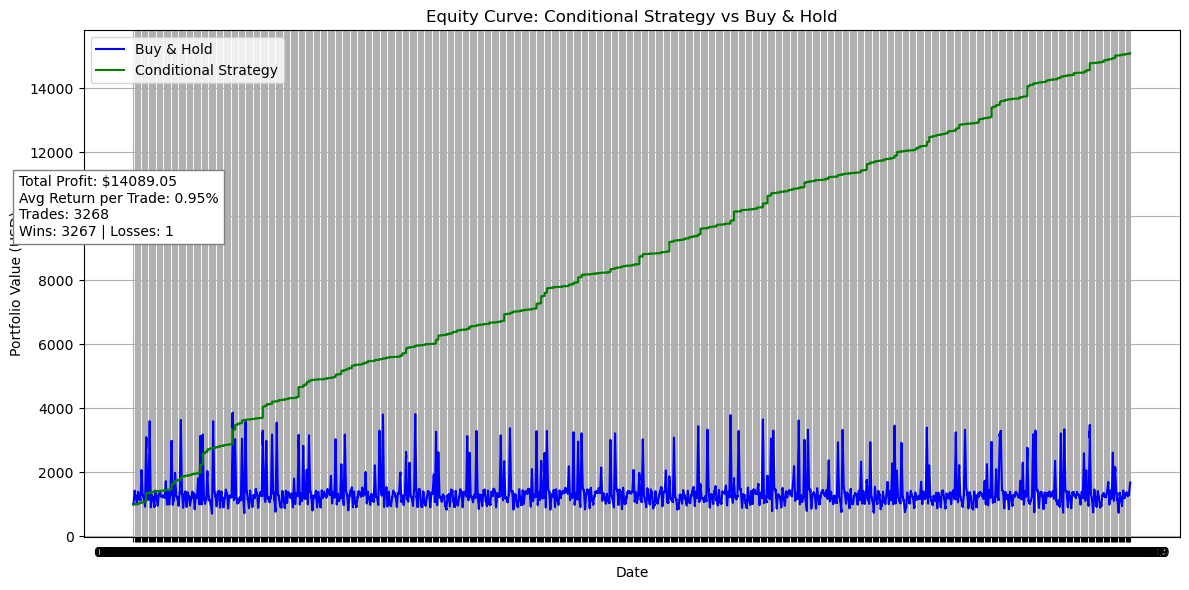

In [560]:
# Recalculate strategy value (optional, in case it's not already done)
initial_capital = 1000
tesla['BuyHold_Value'] = tesla['Close'] / tesla.iloc[0]['Close'] * initial_capital
tesla['Strategy_Value'] = initial_capital + tesla['Cumulative_PnL']

# Strategy metrics
total_profit = trades['PnL'].sum()
avg_return_pct = trades['ReturnPctTrade'].mean()
num_wins = (trades['PnL'] > 0).sum()
num_losses = (trades['PnL'] < 0).sum()
num_trades = len(trades)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['BuyHold_Value'], label='Buy & Hold', color='blue')
plt.plot(tesla['Date'], tesla['Strategy_Value'], label='Conditional Strategy', color='green')

# Title and axis labels
plt.title('Equity Curve: Conditional Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.legend()

# Add a textbox with strategy metrics
metrics_text = (
    f"Total Profit: ${total_profit:.2f}\n"
    f"Avg Return per Trade: {avg_return_pct:.2f}%\n"
    f"Trades: {num_trades}\n"
    f"Wins: {num_wins} | Losses: {num_losses}"
)

# Position the text box on the plot
plt.gcf().text(0.02, 0.6, metrics_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()

### Add trading cost to the strategy

In [562]:
trade_cost = 0.30  # fixed dollar cost per round-trip trade (buy + sell)
threshold = 0.6     # % move from open to trigger trade
stop_loss_pct = 2.0  # % stop loss from open
take_profit_pct = 8.0  # % take profit from open

tesla["Position"] = "None"
tesla["PnL"] = 0.0

tesla["HighReturn"] = (tesla["High"] - tesla["Open"]) / tesla["Open"] * 100
tesla["LowReturn"] = (tesla["Low"] - tesla["Open"]) / tesla["Open"] * 100

for i, row in tesla.iterrows():
    ret = (row["Close"] - row["Open"]) / row["Open"] * 100  # intraday % move

    # ---- Long Position ----
    if ret >= threshold:
        tesla.at[i, "Position"] = "Long"

        if row["LowReturn"] <= -stop_loss_pct:
            stop_price = row["Open"] * (1 - stop_loss_pct / 100)
            tesla.at[i, "PnL"] = stop_price - row["Open"] - trade_cost

        elif row["HighReturn"] >= take_profit_pct:
            tp_price = row["Open"] * (1 + take_profit_pct / 100)
            tesla.at[i, "PnL"] = tp_price - row["Open"] - trade_cost

        else:
            tesla.at[i, "PnL"] = row["Close"] - row["Open"] - trade_cost

    # ---- Short Position ----
    elif ret <= -threshold:
        tesla.at[i, "Position"] = "Short"

        if row["HighReturn"] >= stop_loss_pct:
            stop_price = row["Open"] * (1 + stop_loss_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - stop_price - trade_cost

        elif row["LowReturn"] <= -take_profit_pct:
            tp_price = row["Open"] * (1 - take_profit_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - tp_price - trade_cost

        else:
            tesla.at[i, "PnL"] = row["Open"] - row["Close"] - trade_cost


In [563]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")

Total Profit: $13108.65
Average % Return per Trade: 0.87%
Winning Trades: 3267
Losing Trades: 1


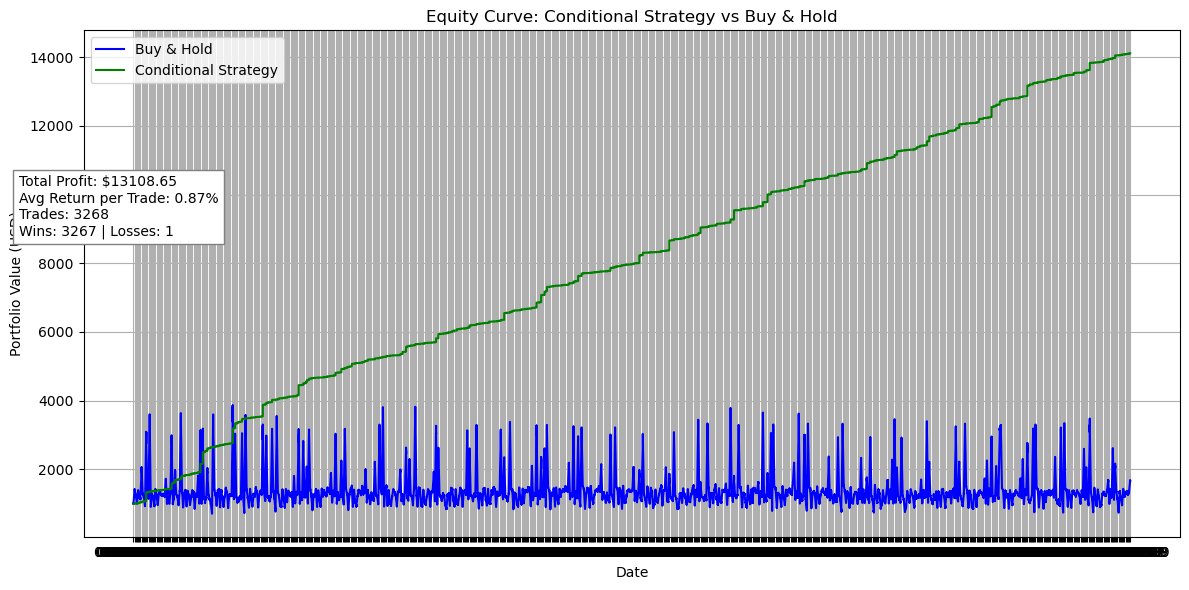

In [564]:
# Plot for the trade cost adjustement.
initial_capital = 1000
tesla['BuyHold_Value'] = tesla['Close'] / tesla.iloc[0]['Close'] * initial_capital
tesla['Strategy_Value'] = initial_capital + tesla['Cumulative_PnL']

# Strategy metrics
total_profit = trades['PnL'].sum()
avg_return_pct = trades['ReturnPctTrade'].mean()
num_wins = (trades['PnL'] > 0).sum()
num_losses = (trades['PnL'] < 0).sum()
num_trades = len(trades)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['BuyHold_Value'], label='Buy & Hold', color='blue')
plt.plot(tesla['Date'], tesla['Strategy_Value'], label='Conditional Strategy', color='green')

# Title and axis labels
plt.title('Equity Curve: Conditional Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.legend()

# Add a textbox with strategy metrics
metrics_text = (
    f"Total Profit: ${total_profit:.2f}\n"
    f"Avg Return per Trade: {avg_return_pct:.2f}%\n"
    f"Trades: {num_trades}\n"
    f"Wins: {num_wins} | Losses: {num_losses}"
)

# Position the text box on the plot
plt.gcf().text(0.02, 0.6, metrics_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()